# Introduction

This notebook is an attempt to implement sentiment analysis using different methods

Starting with methods like Logistic Regression, Latent Dirilecht Analysis, Naive Baiyes etc

We will be using twitter datasets from NLTK

# Imports

In [1]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples, stopwords

from collections import defaultdict

import re
import os  
import string
import numpy as np
import pandas as pd

# Datasets and Few more Initializations

In [2]:
# Download the twitter dataset. This will be the dataset that will be used
nltk.download('twitter_samples')

# Download the english stopwords that will be removed from the tweets during preprocessing
nltk.download('stopwords')


[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Get the positive and negative tweets from twitter_samples. These are of type list
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')


In [4]:
# logging the type and lengths
type(all_positive_tweets), len(all_positive_tweets), len(all_negative_tweets)

(list, 5000, 5000)

 Let's take the last 1000 tweets as the test values for both positive and negative tweets.  
 That will leave the first 4000 tweets as the training data


In [5]:
# Separating positive tweets
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]

# separating negative tweets
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

# Concatenating the positive and negative tweets to form the final test and train datasets
train_x = train_pos + train_neg
test_x = test_pos + test_neg

# Assigning labels 
# 1 = positive tweet and 
# 0 = negative tweet
train_y = [1]*len(train_pos) + [0]*len(train_neg)
test_y = [1]*len(test_pos) + [0]*len(test_neg)



In [6]:
# Showing the final lengths of train and test datasets
len(train_x), len(test_x)

(8000, 2000)

In [7]:
# Showing few positive and negative tweets
print(train_x[:5])
print(train_x[-5:])

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)', '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!', '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!', '@97sides CONGRATS :)', 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days']
['Amelia didnt stalk my twitter :(', 'oh, i missed the broadcast. : (', "i really can't stream on melon i feel useless :-(", 'I need to stop looking at old soccer pictures :(', 'Got an interview for the job that I want but they rang me Tuesday for the interview on Thursday but in on holiday :(']


# Text Preparing

All tweets should be removed of stopwords, urls, hashtags, tweet_ats, stock market tickers converted into tokens

Sequence of steps for preparation:

1.   remove urls in tweets
2.   Remove # and @ symbols
3.   Remove stopwords
4.   Tokenize the tweet
5.   Stem the words in the tweet

**Note**: Stemming gets the words to the root form of the word (need not end up as a proper word in the language like lemmatization would result in)



In [8]:
def process_tweet(tweet):
  # Getting rid of urls in the tweet
  # Below regular expression removes http https links including any with port numbers
  tweet = re.sub(r'http[s][:\/\w]*', '', tweet)

  # Getting rid of @, we will still retain who the tweet is being addressed to by just removing the symbol
  tweet = re.sub(r'@', '', tweet)

  # Getting rid of # symbol, retaining the hashtag name
  tweet = re.sub(r'#', '', tweet)

  # Get the list of stopwords from nltk 
  stopwords_list = set(stopwords.words('english'))
  #Let's print the stopwords as FYI
  #print("stopwords =", stopwords_list)

  # Get a Tokenizer instance
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=False)
  tokens = tokenizer.tokenize(tweet)

  # The tokens generated will have stopwords and words that need to be stemmed
  # Doing both in the next step

  # Initialize a stemmer
  stemmer = PorterStemmer() 
  
  # stem the token if it is not a stopword and it is not a punctuation
  clean_tweet=[stemmer.stem(token) for token in tokens if token not in stopwords_list and token not in string.punctuation ]
  
  return clean_tweet


# Method 1: Logistic Regression

## Preparation for Feature Extraction:
For every word, find the number of times it has been used in a positive tweet and number of times it has been used in a negative tweet


In [9]:
def build_frequencies(tweets, labels):
  '''
  Function to create a list of tuples, each tuple of the form (token, sentiment)

  tweets: list of tweets
  labels: list of labels if it is positive of negative
  '''
  # Using a defaultdict so that in case a key is unavailable, it will return 0 
  # and it will also help in incrementing the frequencies
  freq_list = defaultdict()
  
  # Go through each tweet and label
  for tweet, label in zip(tweets, labels):
    # get tokens from the tweet
    tokens = process_tweet(tweet)
    
    # go through each token and increment the freq_list
    for token in tokens:
      freq_list[(token, label)] = freq_list.get((token, label),0) + 1

  return freq_list

## Extracting Features for LR
We will have two features for LR, for a given tweet, we will get the frequencies for each token used in a positive context and negative context

```
tweet1 Features = sum of positive_freq of words in tweet1, sum of negative_freq of words in tweet1
```

In [10]:
def extract_features(tweets, frequencies):
  '''
  
  tweets = list of tweets
  frequencies = resulting dictionary from the function build_frequencies
  '''
  feature_list = []
  for tweet in tweets:
    # Get the tokens from the tweet
    tokens = process_tweet(tweet)

    # define the features array. 
    # index 0 = positive sentiment
    # index 1 = negative sentiment
    features = np.zeros((2,))

    #go through the tokens and get the sum of positive and negative freqs
    for token in tokens:
      # add the token as a positive sentiment to the positive sentiment feature
      features[0] += frequencies.get((token, 1),0)

      # add the token as a negative sentiment to the negative sentiment feature
      features[1] += frequencies.get((token, 0),0)
    feature_list.append(features)

  return feature_list


In [11]:
print("stopwords =", set(stopwords.words('english')))
# get the frequencies from the training dataset
frequencies = build_frequencies(tweets = train_x, labels = train_y)

# get the features for training
training_features = extract_features(tweets = train_x, frequencies = frequencies)

# get the features for testing
testing_features = extract_features(tweets = test_x, frequencies = frequencies)


stopwords = {'your', 'doesn', 'a', 'more', 'now', 'mustn', 'yourself', 'they', 'their', 'there', 'once', 'being', 'all', 'those', 'into', 'no', 'wasn', 'to', 'out', 'be', 'any', 'too', 'ain', 'again', 'having', 'weren', 'which', 'been', 'such', 'same', 'theirs', 'by', "wouldn't", 't', 'below', 'myself', "shan't", 'am', 'mightn', "mightn't", 'each', 'with', 'and', 'on', "you've", 'about', 'should', 'for', 'here', 'then', 'most', 'has', 'itself', 'through', 'd', "mustn't", 'm', 'shouldn', 'during', "you'll", 'do', 'just', 'didn', 'my', 'yourselves', 'what', 'were', 'couldn', "should've", 'against', 'y', 'ours', 'very', "hasn't", 'that', 'i', 'its', 'them', 'aren', 'we', "isn't", "wasn't", 'she', 'themselves', "you're", "weren't", "don't", 'don', 'hasn', 'these', 'had', 'hers', 'under', "aren't", 'o', 'are', "shouldn't", 'or', 'an', 'did', 'shan', 'needn', 'yours', "won't", 'the', 'ourselves', 'before', 'further', 'but', 'up', 'when', 'from', 'how', 'he', 'why', "didn't", 'haven', 'while'

In [12]:
print("train data =", train_x[0])

print("processed tweet =", process_tweet(train_x[0]))

print("training_features:", training_features[0])

train data = #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
processed tweet = ['followfriday', 'france_int', 'pkuchli', '57', 'milipol_pari', 'top', 'engag', 'member', 'commun', 'week', ':)']
training_features: [3138.   61.]


## Building LR Model

We will implement LR model using Tensorflow as a single unit Dense layer with sigmoid activation function

In [13]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

In [14]:
def lr_model(batch_size=10):
  '''
  function to build logistic regression model using Tensorflow
  '''
  input = Input(shape = (2,), batch_size = batch_size, name='input')
  x = Dense(1, activation='sigmoid', name='dense')(input)

  model = Model(inputs = input, outputs = x, name='lr_model')
  model.summary()
  return model

In [15]:
lr_model = lr_model()
lr_model.compile(optimizer='adam'
                  , loss='binary_crossentropy'
                  , metrics = ['accuracy']
                 )



Model: "lr_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(10, 2)]                 0         
_________________________________________________________________
dense (Dense)                (10, 1)                   3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [16]:
len(training_features)

8000

### Training

In [17]:
metrics = lr_model.fit(x=np.array(training_features)
             , y = np.array(train_y)
             , epochs = 30
             , shuffle=True
             , validation_split=0.1

             )


Epoch 1/30
225/225 [==============================] - 1s 2ms/step - loss: 48.6758 - accuracy: 0.7618 - val_loss: 3.0758 - val_accuracy: 0.9137
Epoch 2/30
225/225 [==============================] - 0s 1ms/step - loss: 1.0620 - accuracy: 0.9674 - val_loss: 1.0216 - val_accuracy: 0.9488
Epoch 3/30
225/225 [==============================] - 0s 1ms/step - loss: 0.4104 - accuracy: 0.9824 - val_loss: 0.4620 - val_accuracy: 0.9688
Epoch 4/30
225/225 [==============================] - 0s 1ms/step - loss: 0.2049 - accuracy: 0.9900 - val_loss: 0.1701 - val_accuracy: 0.9837
Epoch 5/30
225/225 [==============================] - 0s 1ms/step - loss: 0.1257 - accuracy: 0.9932 - val_loss: 0.0834 - val_accuracy: 0.9887
Epoch 6/30
225/225 [==============================] - 0s 1ms/step - loss: 0.1028 - accuracy: 0.9950 - val_loss: 0.0434 - val_accuracy: 0.9937
Epoch 7/30
225/225 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9939 - val_loss: 0.0297 - val_accuracy: 0.9937
Epoch

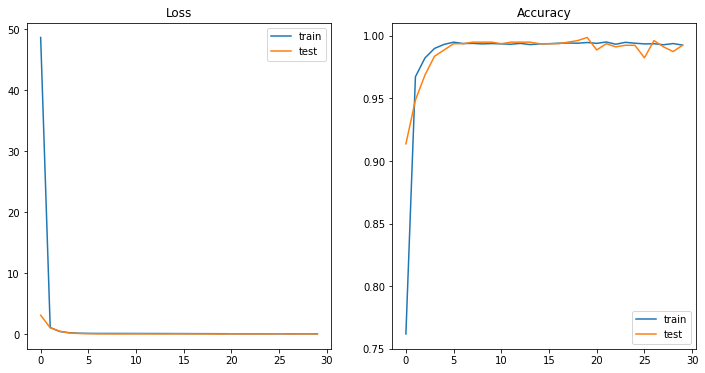

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(metrics.history['loss'], label='train')
plt.plot(metrics.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics.history['accuracy'], label='train')
plt.plot(metrics.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.legend()


### Predictions and Confusion Matrix

In [19]:
y_pred = lr_model.predict(np.array(testing_features))

confusion_matrix = tf.math.confusion_matrix(test_y, y_pred, num_classes=2)

print(confusion_matrix)

tf.Tensor(
[[1000    0]
 [ 305  695]], shape=(2, 2), dtype=int32)


In [20]:
y_pred[:5]

array([[1.        ],
       [1.        ],
       [0.9999888 ],
       [1.        ],
       [0.99979305]], dtype=float32)

# Method 2: Linear Discrimant Analysis (LDA)

In LDA we find the centroids of each class of tweets, use the gap between the centroids as the differentiating factor between the classes



In [21]:
# we need to represent the tweets as vectors, we do this using sklearn's TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tweetVectorizer = TfidfVectorizer(tokenizer = process_tweet
                               , stop_words=list(stopwords.words('english'))
                               )

# Obtaining the vector representations of the tweets
tweetTfidf = tweetVectorizer.fit_transform(train_x)

In [22]:
type(tweetTfidf), tweetTfidf.shape

(scipy.sparse.csr.csr_matrix, (8000, 16652))

In [23]:
tweetTfidf = tweetTfidf.toarray()

## Calculating the centroids

In [24]:
# create a boolean mask to use to calculate the mean
positive_mask = [y == 1 for y in train_y]
print("length of mask = ", len(positive_mask))


# calculating the positive centroid
positive_centroid = tweetTfidf[positive_mask].mean(axis=0)
print("positive centroid = ", positive_centroid.shape, "\n", positive_centroid)

# calculating the negative centroid using a negation of the positive mask
negative_centroid = tweetTfidf[[~val for val in positive_mask]].mean(axis=0)
print("negative centroid =", negative_centroid.shape, "\n", negative_centroid)

# Finding the vector connecting the two centroids
difference = positive_centroid - negative_centroid


length of mask =  8000
positive centroid =  (16652,) 
 [7.10403873e-05 8.27011206e-05 3.69501277e-04 ... 0.00000000e+00
 0.00000000e+00 9.05286295e-05]
negative centroid = (16652,) 
 [0. 0. 0. ... 0. 0. 0.]


## Testing
Predictions are done by 
1. finding the projection of the tweets onto the  vector connecting the positive and negative centroids, 
2. scale the result between the range [0, 1], and 
3. use a threshold like 0.5 or 0.7 to get a binary output prediction

In [25]:
# First we find the tfidfVector representation of the test data
# since the output is a sparse matrix, it is converted to dense
testTfidf = tweetVectorizer.transform(test_x).toarray()

# Calculating the projection of the test data onto the difference vector
testVectorProjection = np.dot(testTfidf, difference)

print("projection shape and few samples = ", testVectorProjection.shape, "\n", testVectorProjection[:5])


projection shape and few samples =  (2000,) 
 [0.00981867 0.02888441 0.01515301 0.01238402 0.02374018]


In [26]:
from sklearn.preprocessing import MinMaxScaler
# instantiate the scaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scale the prediction between 0 and 1
scaled_y_pred = scaler.fit_transform(np.reshape(testVectorProjection, (-1, 1)))
print("sample scaled projecion =", scaled_y_pred[:5])


sample scaled projecion = [[0.70713655]
 [0.78168435]
 [0.72799405]
 [0.71716718]
 [0.76157019]]


In [27]:
# Using threshold as 0.5 to
y_pred = [int(y > 0.7) for y in scaled_y_pred ]

## Confusion Matrix

In [28]:
confusion_matrix = tf.math.confusion_matrix(test_y, y_pred, num_classes=2)
print(confusion_matrix)

tf.Tensor(
[[992   8]
 [157 843]], shape=(2, 2), dtype=int32)


# Method 3: Naiive Bayes

Naiive Bayes assumes that every word is independent of each other
$$sentiment(tweet) = logprior * log(\prod_i^N \frac{p(positive|word)}{p(negative|word)})$$
$$sentiment(tweet) = logprior * \sum_i^N( log(p(positive|word)) - log(p(negative|word)) ) $$
$$sentiment(tweet) = logprior * \sum_i^N(likelihood(word)) $$

where N = Number of words in a tweet

First we calculate the logprior, i.e., log of the ratio probability of positive tweets to negative tweets. This will indicate the bias in the dataset, if any.

$$P(D_{pos}) = \frac{D_{pos}}{D}\tag{1}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}\ $$

where 

* $D_{pos}$ is the number of positive tweets
* $D_{neg}$ is the number of negative tweets
* $D$ is the total number of tweets

$$ logprior = log(\frac{P(D_{pos})}{P(D_{neg})})$$
$$ logprior = log(\frac{D_{pos}}{D_{neg}})$$
$$ logprior = log(D_{pos})-log(D_{neg})$$

Next we find the likelihood of a word in the vocabulary of being positive or negative setiment. 
1. probability of a word being a particular sentiment (using Laplacian smoothing to avoid log(0))
2. likelihood of the word is the log of ratio of probabilities (positive to negative)

$$ p(positive|word) = \frac{freq(word\_as\_positive) + 1}{N_{pos} + V}$$
$$ p(negative|word) = \frac{freq(word\_as\_negative) + 1}{N_{neg} + V}$$

$$ log\_likelihood(word) = log(p(positive|word)) - log(p(negative|word)) $$

where 
* V = vocabulary size
* $N_{pos}$ = Total Number of positive words
* $N_{neg}$ = Total number of negative words

**In conclusion**, likelihood is 
* \> (greater than) 1 if the word tends to be more positively used in the vocabulary
* = 1 if the word is neutral
* \< (less than) 1 if the word tends to be more negatively used in the vocabulary

**And **, log likelihood is
* \>(greater than) 0 if the word is positively used in the vocabulary
* = 0 if the word is neutral
* \<(less than) 0 if the word tends to be more negatively used in the vocabulary


The above steps are the training steps for Naiive Bayes model. The parameters of the model being
1. logprior - float that signifies the bias within the dataset towards a sentiment
2. log likelihood: dictionary of word and its likelihood of a sentiment

## Calculating Model Parameters

In [31]:

def calculate_naiive_bayes_params(tweets, labels):
  '''
  Function to calculate the log prior and log likelihood for a Naiive Bayes model
  tweets: list of tweets, i.e. training dataset
  labels: list of 1-D labels that signify the sentiment of the tweets. This should be the same length as the tweets.
          Assumption is positive sentiment = 1 and negative sentiment = 0

  Returns: a tuple (float, dictionary)
  log_prior: float, log prior of the training dataset provided
  log_likelihood: dictionary, key = token and value = log likelihood of the token
  '''
  # Calculating logprior, total number of positive tweets / total number of negative tweets
  # since positive tweet is represented as 1 and negative tweet is 0, we can put logprior as 
  log_prior = np.log(sum(labels)) - np.log(len(labels) - sum(labels))
  print("logprior = ", log_prior)

  # Next we are going to calculate the log likelihood of the words in the vocab

  # First build the frequencies dictionary key= (token, sentiment) value = frequency
  frequencies = build_frequencies(tweets, labels)

  # We need to know the vocabulary length V, total number of positive words and negative words

  # initialize a set for vocabulary
  vocab = set()
  # initialize the counts of positive and negative tokens
  n_pos = n_neg = 0
  # loop through the frequencies dictionary
  for token, sentiment in frequencies.keys():
    #add the token into the vocabulary set
    # since it is a set, it avoids duplication
    vocab.add(token)

    # increment n_pos and n_neg based on sentiment of the token
    if sentiment == 1: # positive sentiment
      n_pos += 1
    else: # negative sentiment
      n_neg += 1
  print("length of vocab =", len(vocab))
  print("total number of positive tokens =", n_pos)
  print("total number of negative tokens =", n_neg)

  # Going through the vocabulary to create log likehood dictionary
  log_likelihood = defaultdict()

  for token in vocab:
    # Find the likelihood that the token is positive. Include Laplacian smoothing
    likelihood_positive = (frequencies.get((token, 1),0) + 1)/(n_pos + len(vocab)) 

    # Find the likelihood that the token is negative. Include Laplacian smoothing
    likelihood_negative = (frequencies.get((token, 0),0) + 1)/(n_neg + len(vocab))

    # Find the log likelihood of the token
    log_likelihood[token] = np.log(likelihood_positive) - np.log(likelihood_negative)
  
  return log_prior, log_likelihood



## Predicting Sentiments

Given a test tweet, below steps will be followed to make a prediction using Naiive Bayes method
1. Get the tokens from the tweet by calling process_tweet
2. Find the log likelihood of each of the tokens using the dictionary from calculate_naiive_bayes_params function. If a token is not in the log_likelihood dictionary, assume that it is neutral
3. Calculate the log likelihood of the test tweet using the formula: 
$$logprior + \sum  log likelihood(tokens\ in\ the\ test\ tweet)$$
4. If log likelihood of the test tweet is greater than zero, then the sentiment of the tweet is positive, else it is negative


In [33]:
# Get the Naiive Bayes parameters
log_prior, log_likelihood = calculate_naiive_bayes_params(train_x, train_y)

# Initialize an empty list for the predictions
y_pred = []

# Go through each tweet in the testing dataset
for tweet in test_x:
  # Step 1: get the tokens from the tweet
  tokens = process_tweet(tweet)

  # Step 2 and 3: find sum of log likelihood of the tokens
  tweet_log_likelihood = np.sum([log_likelihood.get(token,0) for token in tokens])

  # Step 3: Calculate the sentiment value
  sentiment = log_prior + tweet_log_likelihood

  # Step 4: make final prediction
  if (sentiment >0):
    # Positive sentiment
    y_pred.append(1)
  else:
    # negative sentiment
    y_pred.append(0)


logprior =  0.0
length of vocab = 16674
total number of positive tokens = 10587
total number of negative tokens = 8505


## Confusion Matrix

In [34]:
confusion_matrix = tf.math.confusion_matrix(test_y, y_pred, num_classes=2)
print(confusion_matrix)

tf.Tensor(
[[995   5]
 [  8 992]], shape=(2, 2), dtype=int32)
